# 0. Set Up

In [ ]:
# Librerias
!git clone https://github.com/domingomery/balu3
!pip install ./balu3

Cloning into 'balu3'...
remote: Enumerating objects: 270, done.
remote: Counting objects: 100% (270/270), done.
remote: Compressing objects: 100% (191/191), done.
remote: Total 270 (delta 157), reused 180 (delta 75), pack-reused 0
Receiving objects: 100% (270/270), 71.11 KiB | 5.93 MiB/s, done.
Resolving deltas: 100% (157/157), done.
Processing ./balu3
  Preparing metadata (setup.py) ... done
  Created wheel for balu3: filename=balu3-1.0-py3-none-any.whl size=43701 sha256=9177081e34747fca0f662504f88b46a83769425db1d000edcb6aee063e772349
  Stored in directory: /tmp/pip-ephem-wheel-cache-z4fkngr4/wheels/9e/f6/a9/3d39da83a3504331129d706f5b04ceb3dbf0ec0f313cdb8fcf
Successfully built balu3


In [ ]:
# Numpy & Maplotlib
import numpy             as np
import matplotlib.pyplot as plt
import cv2

# PIL
from PIL import Image

# Balu
from balu3.ft.norm import minmax
from balu3.fx.chr import lbp, haralick, gabor, hog, basicint, contrast, clp
from balu3.fs.sel import jfisher
from balu3.fs.sel import sfs, exsearch, clean
from balu3.fx.geo import basicgeo,fitellipse,hugeo,flusser,gupta
from tqdm.auto import tqdm
from balu3.im.proc import im_grad,fspecial,gradlog
from balu3.ft.trans import pca

# Sklearn
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid # KNN y DMin
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis # LDA
from sklearn.base import BaseEstimator, ClassifierMixin

from sklearn.naive_bayes import GaussianNB  # Naive Bayer
from sklearn.base import BaseEstimator, ClassifierMixin # Bayes KDE
from sklearn.neighbors import KernelDensity

from sklearn.tree import DecisionTreeClassifier # Decision Tree
from sklearn.ensemble import RandomForestClassifier # Random Forest
from sklearn.linear_model import LogisticRegression # Regresion logistica
from sklearn.neural_network import MLPClassifier # NN
from sklearn.svm import SVC # SVM

from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import SelectFromModel


from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE

from sklearn.model_selection import train_test_split

from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import FastICA
from mlxtend.feature_selection import SequentialFeatureSelector as mlxsfs


# 1. Image Loading

In [ ]:
!wget https://www.dropbox.com/scl/fi/1egkpx414yen4affvczw9/jaffec.zip?rlkey=txhzx69hg0wh2xklmg3oc1u6t
!mv jaffec.zip?rlkey=txhzx69hg0wh2xklmg3oc1u6t jaffec.zip
!unzip -qq jaffec.zip

--2024-06-24 00:00:23--  https://www.dropbox.com/scl/fi/1egkpx414yen4affvczw9/jaffec.zip?rlkey=txhzx69hg0wh2xklmg3oc1u6t
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uca0986715538a7104ed8f54c8e7.dl.dropboxusercontent.com/cd/0/inline/CVaHPE7Gzdi28ifNWfobFshqtxlNEJeQQXN78sXlH51UfWaqlXc8HiNWtVxRF0_tPf8foxQAOzlcsohhrmEqRf2xqNrEK1275N13aLaNM2Il6H26En632iVikEWcOsZvFc8/file# [following]
--2024-06-24 00:00:24--  https://uca0986715538a7104ed8f54c8e7.dl.dropboxusercontent.com/cd/0/inline/CVaHPE7Gzdi28ifNWfobFshqtxlNEJeQQXN78sXlH51UfWaqlXc8HiNWtVxRF0_tPf8foxQAOzlcsohhrmEqRf2xqNrEK1275N13aLaNM2Il6H26En632iVikEWcOsZvFc8/file
Resolving uca0986715538a7104ed8f54c8e7.dl.dropboxusercontent.com (uca0986715538a7104ed8f54c8e7.dl.dropboxusercontent.com)... 162.125.1.15, 2620:100:6016:15::a27d:10f
Connecting to uca098671

👉🏻 Las siguientes funciones son auxiliares para cargar las fotos.

**Referencias**:
* Estas funciones las utilice en mi tarea 2.

In [ ]:
def num2fixstr(x: int, d: int) -> str:
    """
    Transforma en un string un numero x en una cantidad de x digitos
    """
    string = '%0*d' % (d, x)
    return string

def get_image_path(num_class: int, num_img: int, sep='_') -> str:
    """
    Retorna la ruta de la imagen a cargar dada una clase num_class y un
    identificador de imagen num_img
    """

    FPATH = 'jaffec'
    PREFIX = 'face'
    img_class = num2fixstr(num_class, 3)
    img_num = num2fixstr(num_img, 5)
    img_path = f'{FPATH}/{PREFIX}_{img_class}_{img_num}.png'

    return img_path

def imageload(num_class: int, num_img: int, echo='off') -> str:
    """
    Carga la imagen
    """
    path = get_image_path(num_class, num_img)
    if echo == 'on':
        print(f'loading image {path} ...')
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    return img

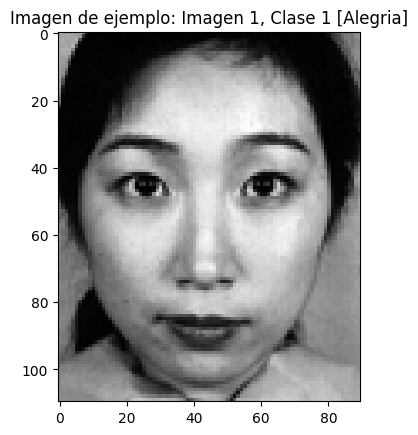

In [ ]:
test_img = imageload(1,1)
plt.title('Imagen de ejemplo: Imagen 1, Clase 1 [Alegria]')
plt.imshow(test_img, cmap='gray')
plt.show()

# 2. Image Preprocessing

👉🏻 Aplicamos el clasificador Haar Cascade preentrenado para detectar el perfil frontal de la cara de una persona.

👉🏻 Luego, aplicamos este clasificador sobre la imagen con los siguientes parametros:
* `scaleFactor = 1.005`: reducimos la imagen 0.5% de su tamaño original
* `minNeighbors = 5`: especifica el numero de rectangulos vecinos que necesita el clasificador para que un objeto se considere valido
* `minSize= (30,50)`: tamaño minimo del objeto a aser detectado.

In [ ]:
def face_detection(img, show=False):
    """
    Funcion que retorna la zona de la imagen en donde se encuentra la cara de una
    persona
    """
    face_classifier = cv2.CascadeClassifier(
        cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
    )
    face = face_classifier.detectMultiScale(
        img, scaleFactor=1.005, minNeighbors=5, minSize=(30, 50)
    )
    x, y, width, height = face[0]
    face_cropped = img[y:(y + height), x:(x + width)]

    if show:
        # Mostramos el resultado de la deteccion de la cara
        img2show = np.copy(img)
        plt.title('Deteccion de la cara')
        cv2.rectangle(img2show, (x, y), (x + width, y + height), (255, 255, 255), 1)
        plt.imshow(img2show, cmap='gray')
        plt.show()

    return face_cropped, (x, y, width, height)


def reshape(img):
    """
    Funcion que realiza un reescalamiento de la foto a una de 75x75
    """
    PIL_img = Image.fromarray(img)
    resized_img = PIL_img.resize((75, 75), Image.LANCZOS) # formato original
    resided_img2array = np.array(resized_img)

    return resided_img2array

def enhance(img):
    """
    Funcion que mejora el contraste de la imagen.
    """
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img_equalized = clahe.apply(img)
    return img_equalized


def preprocess(img, show):
    """
    Funcion que realiza el preprocesamiento de la foto, dejando solo la cara
    de la persona y mejorando detalles faciales.
    """
    # Primero detectamos la cara de la persona
    face, (x, y, width, height) = face_detection(img, show)

    face_cropped = img[y:(y + height), x:(x + width)]
    # Realizamos un reajuste del ancho para eliminar ruido (como el pelo)
    face_reshaped = reshape(face_cropped)
    # Realizamos un reajuste del contraste
    face_enhanced = enhance(face_reshaped)
    return np.bitwise_not(face_enhanced)

def show_all():
    """
    Funcion que retorna todas las fotos preprocesadas de cada mujer
    """
    # Mostramos todas las fotos preprocesadas
    fig, axs = plt.subplots(7, 30, figsize=(30, 7))
    for clase in range(0, 7): # iteramos por todas las clases
        for mujer in range(0, 30): # iteramos por todas las mujeres
            img = imageload(clase + 1, mujer + 1)
            preprocessed_img = preprocess(img, show=False)
            axs[clase, mujer].imshow(preprocessed_img, cmap='gray')
            axs[clase, mujer].axis("off")
    plt.show()

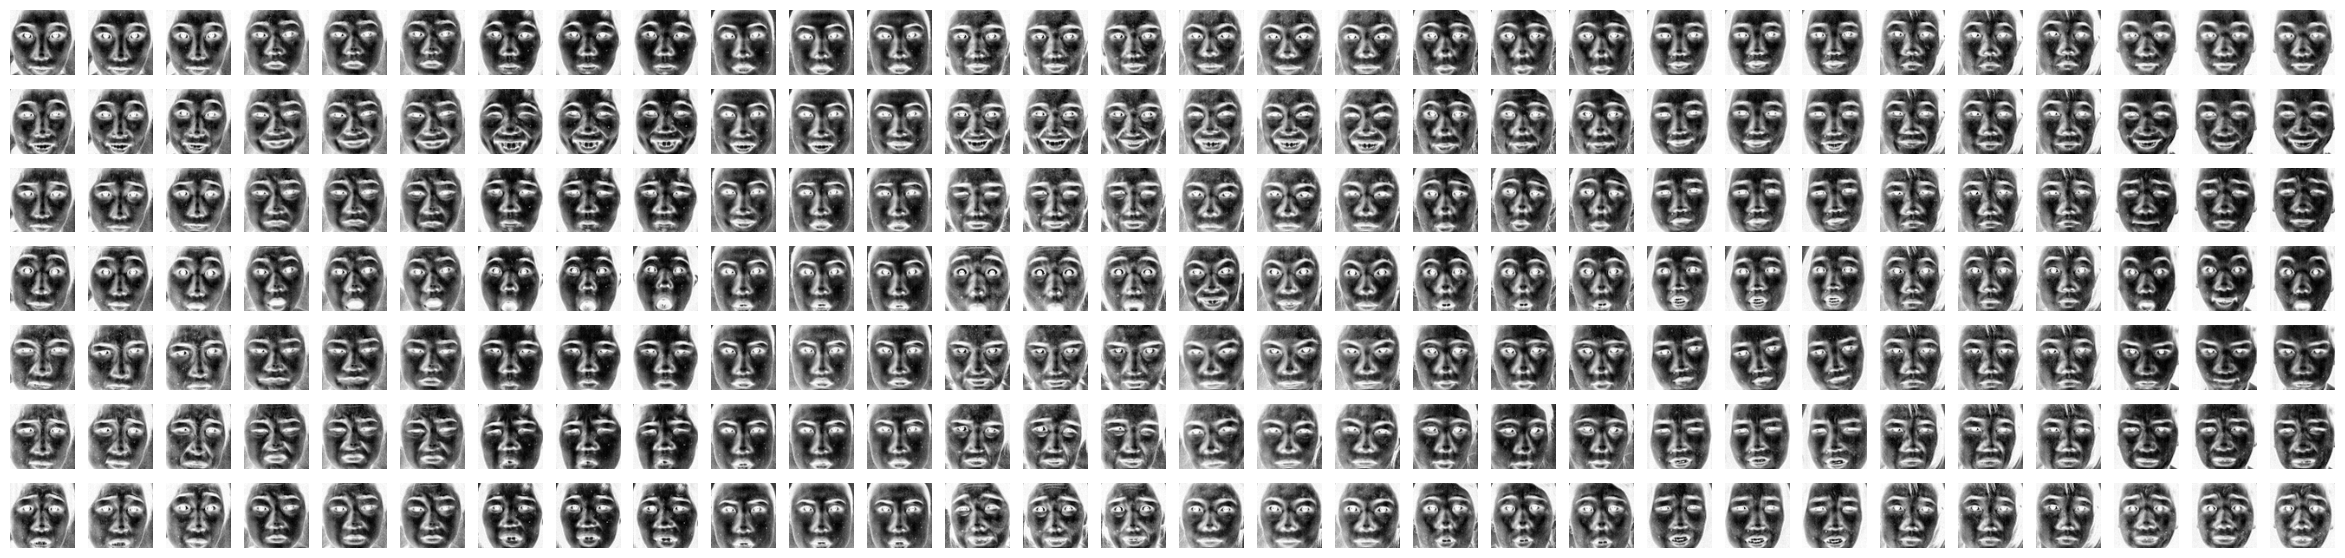

In [ ]:
show_all() # Mostramos todas las imagenes de las mujeres preprocesadas

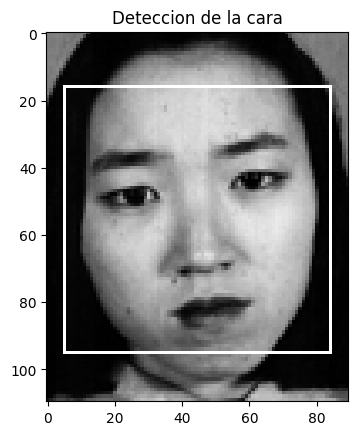

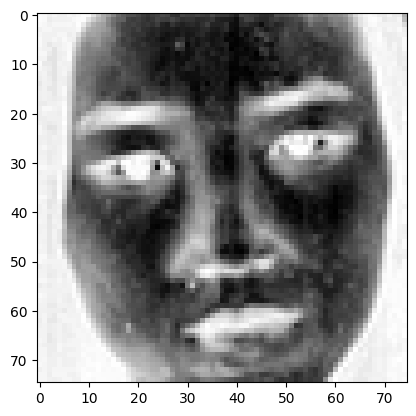

In [ ]:
test_img = imageload(5,22) # ejemplo de imagen preprocesada
pp_test_img = preprocess(test_img, show=True)
plt.imshow(pp_test_img, cmap='gray')
plt.show()

In [ ]:
pp_test_img.shape # tamaño resultante

(75, 75)

# 3. Feature Extraction


👉🏻 Utilizaremos Hog para la extraccion de caracteristicas, ya que queremos obtener caracteristicas de intensidad, lo que tendria buenos resultados para el caso de las expresiones faciales (arrugas, boca, nariz, entre otros)

In [ ]:
K = 7 # Cantidad de clases del dataset
N = 30 # Cantidad de imagenes por clase
y = np.zeros((K * N), 'int') # Vector de clasificacion
# ------------------------------- Hog ------------------------------------------
hog_orientations = 9 # Nueve orientaciones = 9 bins del histograma
px_0 = 8 # Parametro pixeles por bloque: 8 pixeles por bloque
cl_0 = 3 # Parametro celdas por bloque: 3 celdas por bloque
Mhog = 3969 # Numero de elementos en total del vector descriptor


In [ ]:
t = 0
Xhog = np.zeros((K * N, Mhog))
print(f' Extracting features ... '.center(100, '*'))
for k in range(K): # Por cada clase ...
    print(f'Extracting features: batch {k + 1}/7')
    for i in tqdm(range(N)): # Por cada imagen ...
        num_class = k + 1
        num_img = i + 1
        # Cargamos la i-esima imagen de la k-esima clase
        img = imageload(num_class, num_img)

        pp_img = preprocess(img, show=False)
        # Preprocesamos la imagen para eliminar ruido
        # Hog con 9 orientaciones
        Xhog[t,:] = hog(pp_img, orientations=hog_orientations,
                            cells_per_block=(cl_0, cl_0),
                            pixels_per_cell=(px_0, px_0),
                            norm=False)

        # Vector de clasificacion
        y[t] = k + 1 # Deberia ser el mismo para los 3 canales.
        t = t + 1
print(" Features extracted successfully ".center(100, '*'))
X = Xhog
#X = np.concatenate((Xhog, Xlbp), axis = 1)
print(f'{X.shape}'.center(100))

************************************* Extracting features ... **************************************
Extracting features: batch 1/7


  0%|          | 0/30 [00:00<?, ?it/s]

Extracting features: batch 2/7


  0%|          | 0/30 [00:00<?, ?it/s]

Extracting features: batch 3/7


  0%|          | 0/30 [00:00<?, ?it/s]

Extracting features: batch 4/7


  0%|          | 0/30 [00:00<?, ?it/s]

Extracting features: batch 5/7


  0%|          | 0/30 [00:00<?, ?it/s]

Extracting features: batch 6/7


  0%|          | 0/30 [00:00<?, ?it/s]

Extracting features: batch 7/7


  0%|          | 0/30 [00:00<?, ?it/s]

********************************* Features extracted successfully **********************************
                                            (210, 3969)                                             


👉🏻 Dado que en el metodo de estimacion Leave-one-out Person realizaremos todo dentro de la iteracion (tanto Split, Normalization, Clean y Features Selection/Transformation) en las siguientes secciones solo definiremos las funciones a utilizar segun sea el caso.  

# 4. Split Training, Testing y Validation sets

In [ ]:
def split_train_test_val(X, y, i):
    """
    Input: Matriz de caracteristicas X y vector de clases y
    Output: Conjuntos training, testing y validation.
    """
    # i: i-esima mujer
    W = 10
    K = np.max(y) # Cantidad de clases = 7
    N = X.shape[0] // K # Numero de muestras por clase = 30
    N_test = (N // W) * K # numero de muestras de testing = 21
    N_val = (N // W) * K # numero de muestras de validation
    N_train = (N * K) - (N_test + N_val) # numero de muestras de training

    M = X.shape[1]  # Cantidad de caracteristicas

    # Matrices de caracteristicas para Training, testing y Validation.
    Xtrain = np.zeros((N_train, M))
    ytrain = np.zeros((N_train), 'int')

    Xtest = np.zeros((N_test, M))
    ytest = np.zeros((N_test), 'int')

    Xval = np.zeros((N_val, M))
    yval = np.zeros((N_val), 'int')


    t = 0
    itrain = 0
    itest = 0
    ival = 0

    test_start_idx = i * 3
    test_end_idx = test_start_idx + 2
    val_start_idx = ((i + 1) % W) * 3
    val_end_idx = val_start_idx + 2

    for k in range(0, K): # Por cada clase
        for n in range(0, N): # Por cada muestra
            # Testing -> Mujer i
            # Ejemplo: MujerTest = 0, entonces son las imagenes 0 hasta 2
            if test_start_idx <= n <= test_end_idx:
                Xtest[itest,:] = X[t,:]
                ytest[itest] = y[t]
                itest += 1
            # Validation -> Mujer i+1 % 10
            # Ejemplo: MujerVal = 1, entonces son las imagenes 3 hasta 5
            elif val_start_idx <= n <= val_end_idx:
                Xval[ival,:] = X[t,:]
                yval[ival] = y[t]
                ival +=1
            # Training -> Mujeres que no sean ni Mujer test o Mujer validation
            # Ejemplo: MujeresTrain = 2..9, entonces son las imagenes 6 hasta la 29
            else:
                Xtrain[itrain,:] = X[t,:]
                ytrain[itrain] = y[t]
                itrain += 1

            t += 1

    return Xtrain, ytrain, Xtest, ytest, Xval, yval


# 4. Clean and Normalization

In [ ]:
def clean_and_normalize(Xtrain, Xtest, Xval):
  # aplicamos Clean para eliminar las columnas redundantes y evitar nulos
    sclean = clean(Xtrain)
    Xtrain_clean = Xtrain[:, sclean]
    Xtest_clean = Xtest[:, sclean]
    Xval_clean = Xval[:, sclean]
    # aplicamos normalizacion sobre training, y luego escalamos testing y validation.
    Xtrain_norm, a, b = minmax(Xtrain_clean)
    Xtest_norm = Xtest_clean * a + b
    Xval_norm = Xval_clean * a + b
    return Xtrain_norm, Xtest_norm, Xval_norm

# 5. Feature Selection and Transformation

In [ ]:
# Definí esta funcion inicialmente, pero como bajaba el valor de los resultados de accuracies,
# decidi no utilizarla. Toda infomacion era importante :(

def sel_tran_features(Xtrain, ytrain, Xtest, Xval, option):
    """
    Funcion que selecciona las mejores caracteristicas y posteriormente retorna
    una matriz de caracteristicas con las columnas mas representativas.
    """
    if option == 0: # Opcion 0: sin seleccion ni transformacion
        return Xtrain, Xtest, Xval

    elif option == 1: # Opcion 2: SFS + PCA -- (opcion mas alta hasta el momento)
        # SFS - 15 columnas
        #sel = sfs(Xtrain, ytrain, 15, show=True)  # obtenemos las mejores columnas de Xtrain
        #Xtrain_sfs = Xtrain[:, sel]
        #Xtest_sfs = Xtest[:, sel]
        #Xval_sfs = Xval[:, sel]
        # PCA - 10 componentes
        #Xtrain_pca, _, A, Xm, _ = pca(Xtrain_sfs, n_components=10)
        #Xtest_pca               = np.matmul(Xtest_sfs - Xm, A)
        #Xval_pca               = np.matmul(Xval_sfs - Xm, A)
        Xtrain_pca, _, A, Xm, _ = pca(Xtrain, n_components=1000)
        Xtest_pca               = np.matmul(Xtest - Xm, A)
        Xval_pca               = np.matmul(Xval - Xm, A)

        return Xtrain_pca, Xtest_pca, Xval_pca

# 6. Classification

👉🏻 En esta seccion utilizaremos el conjunto de modelos de clasifacion. Todos los guardaremos en un diccionario para probar el mejor modelo posteriormente en la evaluacion.

In [ ]:
# --------------------------------- KNN ------------------------------------
n_neighbors = list(range(1, 30))
knns = [KNeighborsClassifier(n_neighbors = n) for n in n_neighbors]


# --------------------------------- SVM ------------------------------------
kernels = ["linear", 'rbf', 'sigmoid', 'poly']
gammas = [0.01, 0.05, 0.1, 0.25, 0.5, 1]
cs = [0.01, 0.1, 1, 10, 100, 500]
degrees = [2, 5, 10, 12]
svms = []
for kernel in kernels:
  if kernel != 'linear':
    for c in cs:
      for gamma in gammas:
        if kernel == "poly":
          for degree in degrees:
            svms.append(
                SVC(
                    kernel = kernel,
                    C = c,
                    gamma = gamma,
                    degree = degree
                    )
            )
        else:
          svms.append(SVC(kernel = kernel, C = c, gamma = gamma))
  else:
    svms.append(SVC(kernel = kernel))


# ------------------------------ Decision Trees --------------------------------
criterions = ['gini', 'entropy', 'log_loss']
max_depths = [3, 5, 10, 15, 20, 30, 50, 100, 500, 1000, None]

decision_trees = [
    DecisionTreeClassifier(
        max_depth = max_depth_,
        criterion = criterion_
        )
    for max_depth_ in max_depths
    for criterion_ in criterions
]


# ------------------------------ Random Forest ---------------------------------
max_depths = [100, 200, 500, 1000, None]
n_estimators_values = [10, 20, 30, 50, 100, 500, 1000]
random_forests = [
    RandomForestClassifier(
        max_depth = md,
        n_estimators = ne
        )
    for md in max_depths
    for ne in n_estimators_values
]

# --------------------------- Logistic Regression ------------------------------


logistic_regression = [
    LogisticRegression(
        C=c,        )
    for c in [0.01, 0.05, 0.1, 0.2, 0.5, 1]
]

# ---------------------------------- NN ----------------------------------------
neuronal_networks = [
     MLPClassifier(hidden_layer_sizes=(75, 75), learning_rate_init=0.1),
     MLPClassifier(hidden_layer_sizes=(75, 75), learning_rate_init=0.01),
     MLPClassifier(hidden_layer_sizes=(75, 75), learning_rate_init=0.001),
     MLPClassifier(hidden_layer_sizes=(75, 75), learning_rate_init=0.0001),
     MLPClassifier(hidden_layer_sizes=75, learning_rate_init=0.0001),
]

# ---------------------------------- LDA ---------------------------------------

ldas_params = [
    {'solver': 'svd', 'shrinkage': None},
    {'solver': 'lsqr', 'shrinkage': 'auto'},
    {'solver': 'lsqr', 'shrinkage': None},
]
ldas = [LinearDiscriminantAnalysis(**params) for params in ldas_params]
# ---------------------------------- Dmin ---------------------------------------

dmin_metrics = ['euclidean', 'manhattan']
dmins = [NearestCentroid(metric = metric_) for metric_ in dmin_metrics]

# ------------------------------ Naive Bayes -----------------------------------
bayes = [
        GaussianNB(),
        GaussianNB(var_smoothing=1e-7),
        GaussianNB(var_smoothing=1e-5),
        GaussianNB(var_smoothing=1e-3),
        GaussianNB(var_smoothing=1e-1),
]

# -------------------------- Todos los modelos ---------------------------------
h = {
    'knn'       : knns,
    'svm'       : svms,
    'LDA'       : ldas,
    'trees'     : decision_trees,
    'rf'        : random_forests,
    'lreg'      : logistic_regression,
    'NN'        : neuronal_networks,
    'Dmin'      : dmins,
    'Bayes'     : bayes,
}

for name_model, lst_models in h.items():
    print(f'{name_model}\n')
    for model in lst_models:
        print(model)
    print('- '*50)

knn

KNeighborsClassifier(n_neighbors=1)
KNeighborsClassifier(n_neighbors=2)
KNeighborsClassifier(n_neighbors=3)
KNeighborsClassifier(n_neighbors=4)
KNeighborsClassifier()
KNeighborsClassifier(n_neighbors=6)
KNeighborsClassifier(n_neighbors=7)
KNeighborsClassifier(n_neighbors=8)
KNeighborsClassifier(n_neighbors=9)
KNeighborsClassifier(n_neighbors=10)
KNeighborsClassifier(n_neighbors=11)
KNeighborsClassifier(n_neighbors=12)
KNeighborsClassifier(n_neighbors=13)
KNeighborsClassifier(n_neighbors=14)
KNeighborsClassifier(n_neighbors=15)
KNeighborsClassifier(n_neighbors=16)
KNeighborsClassifier(n_neighbors=17)
KNeighborsClassifier(n_neighbors=18)
KNeighborsClassifier(n_neighbors=19)
KNeighborsClassifier(n_neighbors=20)
KNeighborsClassifier(n_neighbors=21)
KNeighborsClassifier(n_neighbors=22)
KNeighborsClassifier(n_neighbors=23)
KNeighborsClassifier(n_neighbors=24)
KNeighborsClassifier(n_neighbors=25)
KNeighborsClassifier(n_neighbors=26)
KNeighborsClassifier(n_neighbors=27)
KNeighborsClassifi

# 7. Evaluation (Leave One Out Person)

👉🏻 En esta seccion evaluaremos cada clasificador mediante el set de validación. Usamos la funcion `leave_one_out_person` para pdoer verificar el rendimiento de modelo clasificando las expresiones faciales de todas las mujeres. En cada iteracion (de las 10 en total), realizamos Split en Xtrain, Xtest y Xval, luego normalizamos y realizamos clean. Y despues buscamos los mejores hiperparametros que maximizan el accuracy del modelo sobre el set de validación. Luego, ya obtenido el mejor modelo, realizamos la predicción sobre el set de testing. Finalmente, retornamos el accuracy promedio que obtuvo el modelo al clasiifcar todas las mujeres, variando sus hiperparámetros.

In [ ]:
def holdout(clf, Xtrain, ytrain, Xtest, ytest):
    # Funcion de evaluacion
    clf.fit(Xtrain, ytrain)
    ypred  = clf.predict(Xtest)
    acc = accuracy_score(ytest, ypred)
    return acc # retornamos el accuracy


In [ ]:
def find_best_model(h, clf_type, Xtrain, ytrain, Xval, yval):
    """
    Funcion que busca el mejor modelo utilizando el set de validacion.
    Retorna el mejor modelo encontrado segun el accuracy maximo.
    """
    q = len(h[clf_type]) # cantidad de clasificadores
    max_acc = 0 # maximo accuracy
    id_best_model = -1 # indice del mejor clasificador encontrado
    for k in range(0, q): # por cada clasificador
        clf = h[clf_type][k] # k-esimo Clasificador 'model'
        acc = holdout(clf, Xtrain, ytrain, Xval, yval) # obtenemos su accuracy
        if acc > max_acc:
            max_acc = acc
            id_best_model = k # mejor clasificador hasta el momento
            print(f'    - Model {k} - accVal: {round(max_acc, 4)} ***')
        else:
            print(f'    - Model {k} - accVal: {round(acc, 4)}')
    print(f'    => Best model finded = {h[clf_type][id_best_model]}')
    return id_best_model


In [ ]:
def leave_one_out(clf_type, X, y):
    """
    Funcion que modela la estrategia Leave One Out Person. Retorna el accuracy
    promedio de un clasificador sobre el set de testing (10 mujeres distintas).
    """
    accuracies = []
    for i in range(0, 10):
        print(f'Validation - Testing Woman ({i + 1})')
        # 1. Realizamos Split sets training, testing y de validacion
        Xtrain, ytrain, Xtest, ytest, Xval, yval = split_train_test_val(X, y, i)

        # 2. Aplicamos Clean y Normalizacion
        Xtrain_norm, Xtest_norm, Xval_norm = clean_and_normalize(Xtrain, Xtest, Xval)

        # 3. Select best model: Buscamos el mejor modelo utilizando el set de validacion
        id_best_model = find_best_model(h, clf_type, Xtrain_norm, ytrain, Xval_norm, yval)

        # 4. Aplicamos el mejor clasificador en testing y obtenemos el accuracy
        best_h = h[clf_type][id_best_model]

        accuracy = holdout(best_h, Xtrain_norm, ytrain, Xtest_norm, ytest)
        print(f'  - accTest: ', accuracy)
        print("-" * 100)
        accuracies.append(accuracy)

    acc = np.mean(accuracies)
    std = np.std(accuracies)
    acc_st = "{:.2f} +/- {:.2f}".format(acc*100,std*100)
    print(f'Accuracy (LOUP) = {acc_st}')
    return f'{clf_type} ' + ', {:2>s}'.format(acc_st), acc


👉🏻 Ahora probaremos cada modelo y elegiremos el que nos de mejor resultados ...

### 7.1 K-Nearest Neighbours (KNN)

In [ ]:
models_list = []

In [ ]:
result_knn, acc_knn = leave_one_out('knn', X, y)
models_list.append((result_knn, acc_knn))

Validation - Testing Woman (1)
    - Model 0 - accVal: 0.5238 ***
    - Model 1 - accVal: 0.381
    - Model 2 - accVal: 0.4286
    - Model 3 - accVal: 0.381
    - Model 4 - accVal: 0.4286
    - Model 5 - accVal: 0.4286
    - Model 6 - accVal: 0.381
    - Model 7 - accVal: 0.381
    - Model 8 - accVal: 0.4286
    - Model 9 - accVal: 0.4762
    - Model 10 - accVal: 0.4762
    - Model 11 - accVal: 0.4762
    - Model 12 - accVal: 0.5238
    - Model 13 - accVal: 0.5238
    - Model 14 - accVal: 0.4762
    - Model 15 - accVal: 0.5238
    - Model 16 - accVal: 0.4286
    - Model 17 - accVal: 0.381
    - Model 18 - accVal: 0.4286
    - Model 19 - accVal: 0.4286
    - Model 20 - accVal: 0.4286
    - Model 21 - accVal: 0.4286
    - Model 22 - accVal: 0.381
    - Model 23 - accVal: 0.381
    - Model 24 - accVal: 0.381
    - Model 25 - accVal: 0.381
    - Model 26 - accVal: 0.381
    - Model 27 - accVal: 0.381
    - Model 28 - accVal: 0.381
    => Best model finded = KNeighborsClassifier(n_neighbors

### 7.2 Support Vector Machine (SVM)

In [ ]:
result_svm, acc_svm = leave_one_out('svm', X, y)
models_list.append((result_svm, acc_svm))

Validation - Testing Woman (1)
    - Model 0 - accVal: 0.5238 ***
    - Model 1 - accVal: 0.5714 ***
    - Model 2 - accVal: 0.1429
    - Model 3 - accVal: 0.1429
    - Model 4 - accVal: 0.1429
    - Model 5 - accVal: 0.1429
    - Model 6 - accVal: 0.2857
    - Model 7 - accVal: 0.5714
    - Model 8 - accVal: 0.1429
    - Model 9 - accVal: 0.1429
    - Model 10 - accVal: 0.1429
    - Model 11 - accVal: 0.1429
    - Model 12 - accVal: 0.2857
    - Model 13 - accVal: 0.6667 ***
    - Model 14 - accVal: 0.1429
    - Model 15 - accVal: 0.1429
    - Model 16 - accVal: 0.1429
    - Model 17 - accVal: 0.1429
    - Model 18 - accVal: 0.1429
    - Model 19 - accVal: 0.6667
    - Model 20 - accVal: 0.1429
    - Model 21 - accVal: 0.1429
    - Model 22 - accVal: 0.1429
    - Model 23 - accVal: 0.1429
    - Model 24 - accVal: 0.1429
    - Model 25 - accVal: 0.6667
    - Model 26 - accVal: 0.1429
    - Model 27 - accVal: 0.1429
    - Model 28 - accVal: 0.1429
    - Model 29 - accVal: 0.1429
    - M

### 7.3 LDA

In [ ]:
result_lda, acc_lda = leave_one_out('LDA', X, y)
models_list.append((result_lda, acc_lda))

Validation - Testing Woman (1)
    - Model 0 - accVal: 0.7143 ***
    - Model 1 - accVal: 0.7619 ***
    - Model 2 - accVal: 0.0476
    => Best model finded = LinearDiscriminantAnalysis(shrinkage='auto', solver='lsqr')
  - accTest:  0.6666666666666666
----------------------------------------------------------------------------------------------------
Validation - Testing Woman (2)
    - Model 0 - accVal: 0.7143 ***
    - Model 1 - accVal: 0.6667
    - Model 2 - accVal: 0.0476
    => Best model finded = LinearDiscriminantAnalysis()
  - accTest:  0.6666666666666666
----------------------------------------------------------------------------------------------------
Validation - Testing Woman (3)
    - Model 0 - accVal: 0.4286 ***
    - Model 1 - accVal: 0.4286
    - Model 2 - accVal: 0.1429
    => Best model finded = LinearDiscriminantAnalysis()
  - accTest:  0.7142857142857143
----------------------------------------------------------------------------------------------------
Validation 

### 7.4 DMIN

In [ ]:
result_dmin, acc_dmin = leave_one_out('Dmin', X, y)
models_list.append((result_dmin, acc_dmin))

Validation - Testing Woman (1)
    - Model 0 - accVal: 0.619 ***
    - Model 1 - accVal: 0.5714
    => Best model finded = NearestCentroid()
  - accTest:  0.8095238095238095
----------------------------------------------------------------------------------------------------
Validation - Testing Woman (2)
    - Model 0 - accVal: 0.619 ***
    - Model 1 - accVal: 0.6667 ***
    => Best model finded = NearestCentroid(metric='manhattan')
  - accTest:  0.5238095238095238
----------------------------------------------------------------------------------------------------
Validation - Testing Woman (3)
    - Model 0 - accVal: 0.5714 ***
    - Model 1 - accVal: 0.5238
    => Best model finded = NearestCentroid()
  - accTest:  0.8571428571428571
----------------------------------------------------------------------------------------------------
Validation - Testing Woman (4)
    - Model 0 - accVal: 0.7143 ***
    - Model 1 - accVal: 0.6667
    => Best model finded = NearestCentroid()
  - accTes

### 7.5 Naive Bayes

In [ ]:
result_bayes, acc_bayes = leave_one_out('Bayes', X, y)
models_list.append((result_bayes, acc_bayes))

Validation - Testing Woman (1)
    - Model 0 - accVal: 0.5714 ***
    - Model 1 - accVal: 0.5714
    - Model 2 - accVal: 0.5714
    - Model 3 - accVal: 0.619 ***
    - Model 4 - accVal: 0.5714
    => Best model finded = GaussianNB(var_smoothing=0.001)
  - accTest:  0.5714285714285714
----------------------------------------------------------------------------------------------------
Validation - Testing Woman (2)
    - Model 0 - accVal: 0.619 ***
    - Model 1 - accVal: 0.619
    - Model 2 - accVal: 0.619
    - Model 3 - accVal: 0.619
    - Model 4 - accVal: 0.5238
    => Best model finded = GaussianNB()
  - accTest:  0.47619047619047616
----------------------------------------------------------------------------------------------------
Validation - Testing Woman (3)
    - Model 0 - accVal: 0.4286 ***
    - Model 1 - accVal: 0.4286
    - Model 2 - accVal: 0.4286
    - Model 3 - accVal: 0.4286
    - Model 4 - accVal: 0.6667 ***
    => Best model finded = GaussianNB(var_smoothing=0.1)
  

### 7.6 Decision Trees

In [ ]:
result_trees, acc_trees = leave_one_out('trees', X, y)
models_list.append((result_trees, acc_trees))

Validation - Testing Woman (1)
    - Model 0 - accVal: 0.2857 ***
    - Model 1 - accVal: 0.381 ***
    - Model 2 - accVal: 0.381
    - Model 3 - accVal: 0.5238 ***
    - Model 4 - accVal: 0.381
    - Model 5 - accVal: 0.2857
    - Model 6 - accVal: 0.5238
    - Model 7 - accVal: 0.3333
    - Model 8 - accVal: 0.2857
    - Model 9 - accVal: 0.3333
    - Model 10 - accVal: 0.3333
    - Model 11 - accVal: 0.2857
    - Model 12 - accVal: 0.4286
    - Model 13 - accVal: 0.3333
    - Model 14 - accVal: 0.2857
    - Model 15 - accVal: 0.5238
    - Model 16 - accVal: 0.2857
    - Model 17 - accVal: 0.2857
    - Model 18 - accVal: 0.2857
    - Model 19 - accVal: 0.3333
    - Model 20 - accVal: 0.3333
    - Model 21 - accVal: 0.4286
    - Model 22 - accVal: 0.2857
    - Model 23 - accVal: 0.2381
    - Model 24 - accVal: 0.4286
    - Model 25 - accVal: 0.2857
    - Model 26 - accVal: 0.2857
    - Model 27 - accVal: 0.5238
    - Model 28 - accVal: 0.2857
    - Model 29 - accVal: 0.3333
    - Mode

### 7.7 Random Forest

In [ ]:
result_rf, acc_rf = leave_one_out('rf', X, y)
models_list.append((result_rf, acc_rf))

Validation - Testing Woman (1)
    - Model 0 - accVal: 0.4286 ***
    - Model 1 - accVal: 0.4286
    - Model 2 - accVal: 0.4286
    - Model 3 - accVal: 0.5238 ***
    - Model 4 - accVal: 0.7143 ***
    - Model 5 - accVal: 0.5238
    - Model 6 - accVal: 0.619
    - Model 7 - accVal: 0.4286
    - Model 8 - accVal: 0.4286
    - Model 9 - accVal: 0.4286
    - Model 10 - accVal: 0.6667
    - Model 11 - accVal: 0.619
    - Model 12 - accVal: 0.7143
    - Model 13 - accVal: 0.6667
    - Model 14 - accVal: 0.2857
    - Model 15 - accVal: 0.5238
    - Model 16 - accVal: 0.4762
    - Model 17 - accVal: 0.381
    - Model 18 - accVal: 0.381
    - Model 19 - accVal: 0.5714
    - Model 20 - accVal: 0.7143
    - Model 21 - accVal: 0.4286
    - Model 22 - accVal: 0.4286
    - Model 23 - accVal: 0.5714
    - Model 24 - accVal: 0.5714
    - Model 25 - accVal: 0.7143
    - Model 26 - accVal: 0.619
    - Model 27 - accVal: 0.619
    - Model 28 - accVal: 0.3333
    - Model 29 - accVal: 0.381
    - Model 30

### 7.8 Logistic Regression

In [ ]:
result_lreg, acc_lreg = leave_one_out('lreg', X, y)
models_list.append((result_lreg, acc_lreg))

Validation - Testing Woman (1)
    - Model 0 - accVal: 0.5238 ***
    - Model 1 - accVal: 0.5714 ***
    - Model 2 - accVal: 0.619 ***
    - Model 3 - accVal: 0.619
    - Model 4 - accVal: 0.619
    - Model 5 - accVal: 0.6667 ***
    => Best model finded = LogisticRegression(C=1)
  - accTest:  0.7142857142857143
----------------------------------------------------------------------------------------------------
Validation - Testing Woman (2)
    - Model 0 - accVal: 0.7143 ***
    - Model 1 - accVal: 0.7619 ***
    - Model 2 - accVal: 0.7619
    - Model 3 - accVal: 0.7143
    - Model 4 - accVal: 0.7143
    - Model 5 - accVal: 0.7143
    => Best model finded = LogisticRegression(C=0.05)
  - accTest:  0.5238095238095238
----------------------------------------------------------------------------------------------------
Validation - Testing Woman (3)
    - Model 0 - accVal: 0.5238 ***
    - Model 1 - accVal: 0.5238
    - Model 2 - accVal: 0.5238
    - Model 3 - accVal: 0.5238
    - Model 4

### 7.9 Redes Neuronales

In [ ]:
result_nn, acc_nn = leave_one_out('NN', X, y)
models_list.append((result_nn, acc_nn))

Validation - Testing Woman (1)
    - Model 0 - accVal: 0.1429 ***
    - Model 1 - accVal: 0.2381 ***
    - Model 2 - accVal: 0.6667 ***
    - Model 3 - accVal: 0.619
    - Model 4 - accVal: 0.6667
    => Best model finded = MLPClassifier(hidden_layer_sizes=(75, 75))
  - accTest:  0.6666666666666666
----------------------------------------------------------------------------------------------------
Validation - Testing Woman (2)
    - Model 0 - accVal: 0.1429 ***
    - Model 1 - accVal: 0.2857 ***
    - Model 2 - accVal: 0.8571 ***
    - Model 3 - accVal: 0.7619
    - Model 4 - accVal: 0.8095
    => Best model finded = MLPClassifier(hidden_layer_sizes=(75, 75))
  - accTest:  0.5238095238095238
----------------------------------------------------------------------------------------------------
Validation - Testing Woman (3)
    - Model 0 - accVal: 0.1429 ***
    - Model 1 - accVal: 0.3333 ***
    - Model 2 - accVal: 0.4286 ***
    - Model 3 - accVal: 0.4286
    - Model 4 - accVal: 0.4762

## Resultados

In [ ]:
models_list

[('knn , 56.67 +/- 21.56', 0.5666666666666667),
 ('svm , 58.10 +/- 18.05', 0.5809523809523809),
 ('LDA , 57.62 +/- 15.13', 0.5761904761904761),
 ('Dmin , 61.43 +/- 17.23', 0.6142857142857141),
 ('Bayes , 63.33 +/- 11.28', 0.6333333333333334),
 ('trees , 28.57 +/- 12.42', 0.2857142857142857),
 ('rf , 56.19 +/- 17.14', 0.5619047619047619),
 ('lreg , 67.62 +/- 19.61', 0.6761904761904762),
 ('NN , 62.38 +/- 18.25', 0.6238095238095238)]

In [171]:
models_list = sorted(models_list, key = lambda x: -x[1])

for result, accuracy in models_list:
    print("{:^20s} | {:>10}".format(result, accuracy))
print()
print(" Mejor modelo ".center(50, "*"))
print(f'{models_list[0][0]} {models_list[0][1]}'.center(50))


lreg , 67.62 +/- 19.61 | 0.6761904761904762
Bayes , 63.33 +/- 11.28 | 0.6333333333333334
NN , 62.38 +/- 18.25 | 0.6238095238095238
Dmin , 61.43 +/- 17.23 | 0.6142857142857141
svm , 58.10 +/- 18.05 | 0.5809523809523809
LDA , 57.62 +/- 15.13 | 0.5761904761904761
knn , 56.67 +/- 21.56 | 0.5666666666666667
rf , 56.19 +/- 17.14 | 0.5619047619047619
trees , 28.57 +/- 12.42 | 0.2857142857142857

****************** Mejor modelo ******************
    lreg , 67.62 +/- 19.61 0.6761904761904762     


👉🏻 Por lo tanto, el mejor modelo que nos quedaremos será **Regresion Logística**. Teniendo un accuracy promedio de un 67.62% y  una desviación estandar de 19.61.

# Referencias


* [Face Detection | Python OpenCV](https://www.datacamp.com/tutorial/face-detection-python-opencv): en el siguiente link lo utilice en la seccion de preprocesamiento de los datos. Es un tutorial que me ayudo para detectar los rostros en las imagenes.
